
# Malaria Detection Using TensorFlow Datasets

This notebook demonstrates the step-by-step process of building a Convolutional Neural Network (CNN) to classify cell images as **Parasitized** or **Uninfected** using TensorFlow Datasets (TFDS). The notebook includes:
- Loading and preprocessing the dataset.
- Visualizing data distributions and augmentations.
- Training two models: one without data augmentation and one with augmentation.
- Comparing the models using confusion matrices, accuracy/loss plots, and evaluation metrics.


In [13]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras.models import clone_model
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Data Loading and Preprocessing

In [14]:
# Load the Malaria dataset
print("Loading the Malaria dataset...")
dataset, info = tfds.load(
    'malaria',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)
train_data, validation_data, test_data = dataset

print(f"Train size: {info.splits['train'].num_examples * 0.8:.0f}")
print(f"Validation size: {info.splits['train'].num_examples * 0.1:.0f}")
print(f"Test size: {info.splits['train'].num_examples * 0.1:.0f}")

# Define a preprocessing function
def preprocess_image(image, label):
    image = tf.image.resize(image, (130, 130))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing
train_data = train_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch
batch_size = 32
train_data = train_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)


Loading the Malaria dataset...
Train size: 22046
Validation size: 2756
Test size: 2756


## Data Visualizations

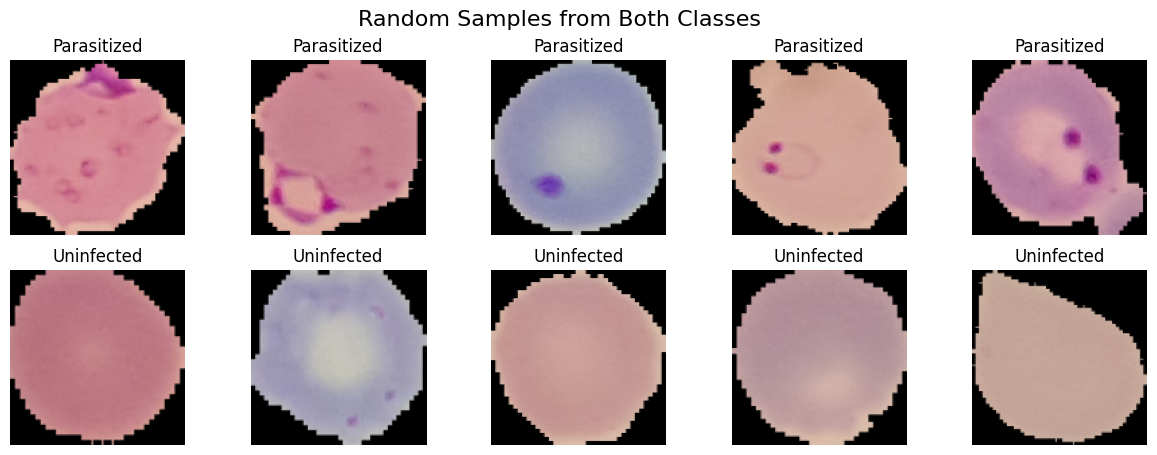

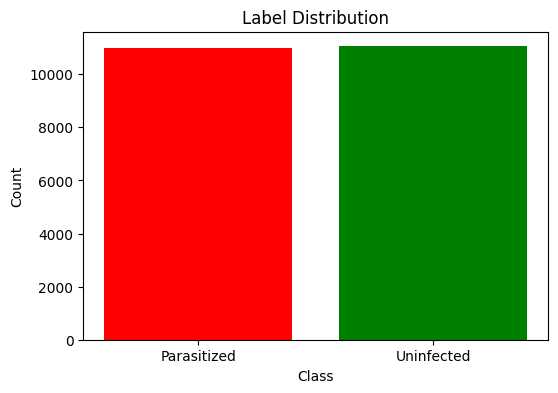

Number of duplicate images: 0


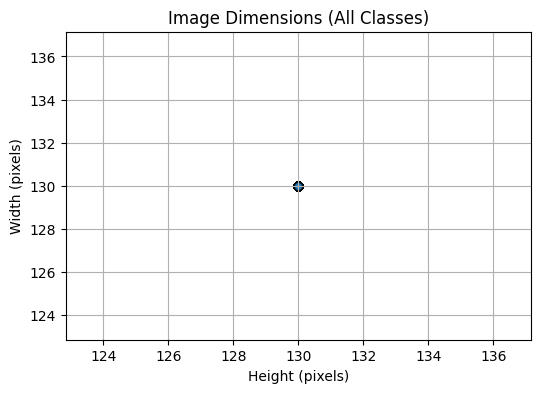

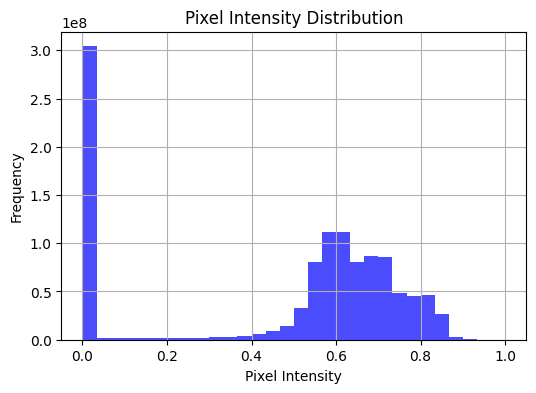

No low intensity outliers detected.
No high intensity outliers detected.


In [15]:
# Comprehensive Data Exploration and Visualization
def explore_and_visualize(dataset, num_samples=5):
    """Comprehensive visualization for exploring an image dataset."""
    import numpy as np
    import matplotlib.pyplot as plt
    from collections import Counter

    # Extract all data from the dataset for analysis
    images = []
    labels = []
    for image, label in dataset.unbatch():
        images.append(image.numpy())
        labels.append(label.numpy())

    images = np.array(images)
    labels = np.array(labels)

    # 1. Random Samples for Both Classes
    def plot_class_samples(images, labels, num_samples, title):
        plt.figure(figsize=(15, 5))
        classes = [0, 1]  # 0: Parasitized, 1: Uninfected
        for cls in classes:
            class_images = images[labels == cls][:num_samples]
            for i, img in enumerate(class_images):
                plt.subplot(len(classes), num_samples, cls * num_samples + i + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title("Parasitized" if cls == 0 else "Uninfected")
        plt.suptitle(title, fontsize=16)
        plt.show()

    plot_class_samples(images, labels, num_samples, "Random Samples from Both Classes")

    # 2. Label Distribution
    label_counts = Counter(labels)
    plt.figure(figsize=(6, 4))
    plt.bar(["Parasitized", "Uninfected"], [label_counts[0], label_counts[1]], color=["red", "green"])
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Label Distribution")
    plt.show()

    # 3. Check for Duplicate Images
    unique_images = np.unique(images, axis=0)
    num_duplicates = len(images) - len(unique_images)
    print(f"Number of duplicate images: {num_duplicates}")
    if num_duplicates > 0:
        plt.figure(figsize=(10, 5))
        plt.imshow(images[0])  # Show one duplicate image
        plt.title("Example Duplicate Image")
        plt.axis('off')
        plt.show()

    # 4. Image Dimensions
    heights, widths = zip(*[(img.shape[0], img.shape[1]) for img in images])
    plt.figure(figsize=(6, 4))
    plt.scatter(heights, widths, alpha=0.7, edgecolor="k")
    plt.xlabel("Height (pixels)")
    plt.ylabel("Width (pixels)")
    plt.title("Image Dimensions (All Classes)")
    plt.grid(True)
    plt.show()

    # 5. Pixel Intensity Distribution
    pixel_samples = images.flatten()
    plt.figure(figsize=(6, 4))
    plt.hist(pixel_samples, bins=30, color="blue", alpha=0.7)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title("Pixel Intensity Distribution")
    plt.grid(True)
    plt.show()

    # 6. Outlier Detection (Images with High/Low Mean Intensity)
    mean_intensities = images.mean(axis=(1, 2, 3))  # Mean intensity per image
    outlier_threshold = 0.1  # Customize threshold
    low_intensity_outliers = images[mean_intensities < outlier_threshold]
    high_intensity_outliers = images[mean_intensities > 0.9]

    def plot_outliers(outliers, title):
        if len(outliers) > 0:
            plt.figure(figsize=(15, 5))
            for i, img in enumerate(outliers[:num_samples]):
                plt.subplot(1, num_samples, i + 1)
                plt.imshow(img)
                plt.axis('off')
            plt.suptitle(title, fontsize=16)
            plt.show()
        else:
            print(f"No {title.lower()} detected.")

    plot_outliers(low_intensity_outliers, "Low Intensity Outliers")
    plot_outliers(high_intensity_outliers, "High Intensity Outliers")

# Run the visualization on the training data
explore_and_visualize(train_data)


## Model Building

In [16]:
# Define CNN model
def build_model(input_shape=(130, 130, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


# Train and Save Models With and Without Data Augmentation

### Step 1: Compile and Train the Model Without Augmentation
- Build and compile a CNN for binary classification (Parasitized vs. Uninfected).
- Train the model without applying any data augmentation to the dataset.
- Early stopping is used to prevent overfitting by halting training when the validation loss stops improving.

### Step 2: Save the Model Trained Without Augmentation
- Save the trained model (`model_no_aug.h5`) for future use, ensuring that the baseline model is preserved.

### Step 3: Clone the Trained Model for Augmented Training
- Clone the model trained without augmentation, preserving its architecture and weights.
- This cloned model will be used for further training with data augmentation.

### Step 4: Define Data Augmentation Techniques
- Apply random flipping, rotation, and zoom to the training images to create a more diverse dataset.
- Data augmentation enhances the model's ability to generalize by introducing variability.

### Step 5: Train the Model With Augmented Data
- Train the cloned model (`model_aug`) on the augmented dataset while using the same validation set for consistency.
- Early stopping is also applied to the augmented training process.

### Step 6: Save the Model Trained With Augmentation
- Save the model trained with augmented data (`model_aug.h5`) for comparison with the non-augmented model.


In [17]:


# Compile and train model without augmentation
model_no_aug = build_model()
model_no_aug.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Train the model without augmentation
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_no_aug = model_no_aug.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    callbacks=[early_stopping]
)

# Save the model trained without augmentation
model_no_aug.save('model_no_aug.h5')
print("Model trained without augmentation saved.")

# Clone the trained model for augmentation
model_aug = clone_model(model_no_aug)
model_aug.set_weights(model_no_aug.get_weights())  # Copy the weights
model_aug.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Augment training data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

def preprocess_with_augmentation(image, label):
    image = data_augmentation(image)
    return image, label

train_data_augmented = train_data.map(preprocess_with_augmentation)

# Train the augmented model
history_aug = model_aug.fit(
    train_data_augmented,
    validation_data=validation_data,
    epochs=10,
    callbacks=[early_stopping]
)

# Save the model trained with augmentation
model_aug.save('model_aug.h5')
print("Model trained with augmentation saved.")



Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 137s 195ms/step - accuracy: 0.7120 - loss: 0.5250 - val_accuracy: 0.9303 - val_loss: 0.1900
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 142s 205ms/step - accuracy: 0.9410 - loss: 0.1720 - val_accuracy: 0.9550 - val_loss: 0.1567
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 139s 201ms/step - accuracy: 0.9544 - loss: 0.1400 - val_accuracy: 0.9543 - val_loss: 0.1526
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 125s 182ms/step - accuracy: 0.9598 - loss: 0.1250 - val_accuracy: 0.9536 - val_loss: 0.1497
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 128s 185ms/step - accuracy: 0.9627 - loss: 0.1086 - val_accuracy: 0.9554 - val_loss: 0.1451
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 127s 185ms/step - accuracy: 0.9649 - loss: 0.0986 - val_accuracy: 0.9575 - val_loss: 0.1445
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 124s 181ms/step - accuracy: 0.9728 - loss: 0.0841 - val_accuracy: 0.9543 - val_loss: 0.1567
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 138s 200ms/step - accuracy: 0.9739 -

Model trained without augmentation saved.
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 165s 237ms/step - accuracy: 0.9530 - loss: 0.1606 - val_accuracy: 0.9470 - val_loss: 0.1508
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 161s 233ms/step - accuracy: 0.9551 - loss: 0.1416 - val_accuracy: 0.9507 - val_loss: 0.1429
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 228ms/step - accuracy: 0.9561 - loss: 0.1370 - val_accuracy: 0.9554 - val_loss: 0.1398
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 163s 236ms/step - accuracy: 0.9573 - loss: 0.1319 - val_accuracy: 0.9568 - val_loss: 0.1352
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 159s 231ms/step - accuracy: 0.9577 - loss: 0.1298 - val_accuracy: 0.9575 - val_loss: 0.1287
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 159s 231ms/step - accuracy: 0.9586 - loss: 0.1298 - val_accuracy: 0.9565 - val_loss: 0.1422
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 160s 232ms/step - accuracy: 0.9571 - loss: 0.1301 - val_accuracy: 0.9568 - val_loss: 0.1331
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━

Model trained with augmentation saved.


## Evaluate and Compare Models

# Step 7: Evaluate and Compare Both Models

### Purpose:
In this step, we evaluate the performance of the two models—trained with and without data augmentation—on the test dataset. The evaluation includes:
- **Test Loss**: The error value calculated on the test dataset.
- **Test Accuracy**: The percentage of correctly classified samples in the test dataset.

### Comparison:
- Print the test accuracy and test loss for both models to understand how data augmentation impacts the model's generalization on unseen data.
- This step provides insights into the trade-offs between the two approaches.


In [18]:
# Evaluate both models on the test dataset
test_loss_no_aug, test_accuracy_no_aug = model_no_aug.evaluate(test_data, verbose=0)
test_loss_aug, test_accuracy_aug = model_aug.evaluate(test_data, verbose=0)

print(f"Model without augmentation - Test Accuracy: {test_accuracy_no_aug:.2%}, Test Loss: {test_loss_no_aug:.4f}")
print(f"Model with augmentation - Test Accuracy: {test_accuracy_aug:.2%}, Test Loss: {test_loss_aug:.4f}")



Model without augmentation - Test Accuracy: 96.04%, Test Loss: 0.1489
Model with augmentation - Test Accuracy: 95.97%, Test Loss: 0.1380


# Visualize and Compare Training Histories for Both Models

### Purpose:
- This step visualizes the training and validation accuracy and loss for both models:
  - **Model Without Augmentation**: Trained on the original dataset without data augmentation.
  - **Model With Augmentation**: Trained on the augmented dataset.

### Insights:
- **Accuracy Plot**:
  - Displays how the training and validation accuracy evolved over the epochs for both models.
  - Helps identify overfitting or underfitting.
  
- **Loss Plot**:
  - Shows the training and validation loss over epochs.
  - Highlights whether the models are learning effectively and converging.

### Steps:
1. Plot training and validation accuracy for both models side by side.
2. Plot training and validation loss for both models side by side.
3. Compare the trends to determine which model performs better during training and validation.


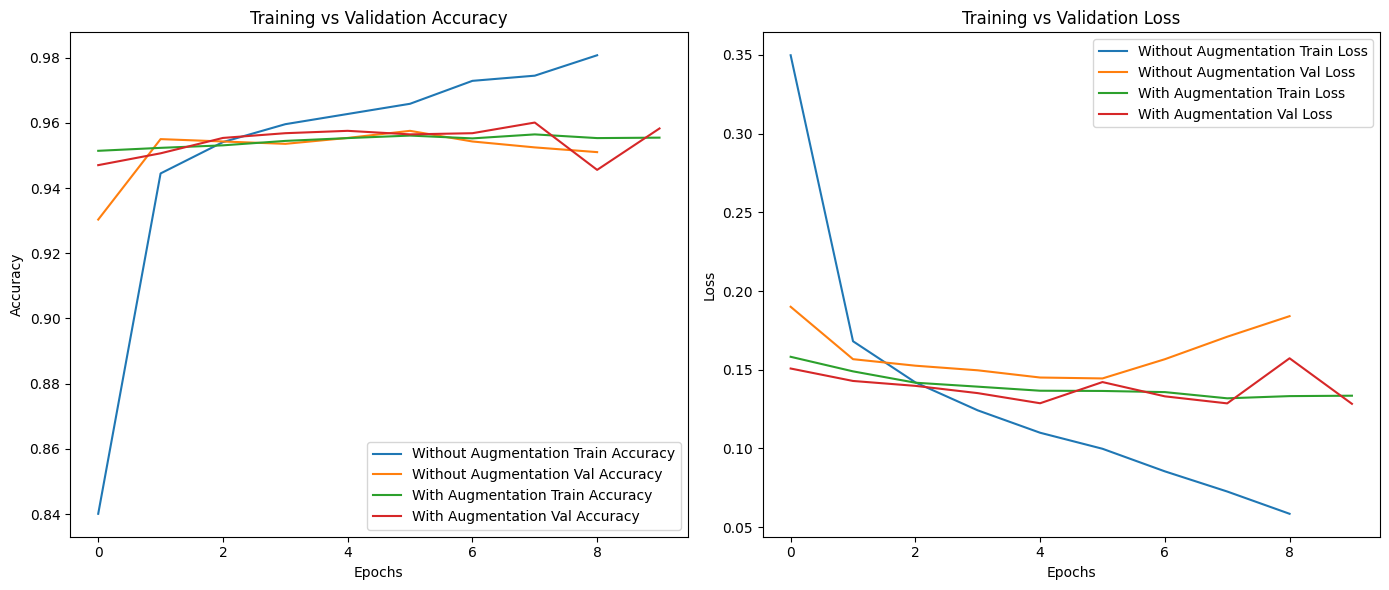

In [19]:
# Plot training history for both models
def plot_training_histories(history1, history2, title1="Without Augmentation", title2="With Augmentation"):
    plt.figure(figsize=(14, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label=f'{title1} Train Accuracy')
    plt.plot(history1.history['val_accuracy'], label=f'{title1} Val Accuracy')
    plt.plot(history2.history['accuracy'], label=f'{title2} Train Accuracy')
    plt.plot(history2.history['val_accuracy'], label=f'{title2} Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label=f'{title1} Train Loss')
    plt.plot(history1.history['val_loss'], label=f'{title1} Val Loss')
    plt.plot(history2.history['loss'], label=f'{title2} Train Loss')
    plt.plot(history2.history['val_loss'], label=f'{title2} Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')

    plt.tight_layout()
    plt.show()

# Plot the comparison
plot_training_histories(history_no_aug, history_aug)



# Generate and Compare Confusion Matrices for Both Models

### Purpose:
- The confusion matrix provides a detailed breakdown of the model's classification performance, showing:
  - **True Positives (TP)**: Correctly classified parasitized cases.
  - **True Negatives (TN)**: Correctly classified uninfected cases.
  - **False Positives (FP)**: Uninfected cases misclassified as parasitized.
  - **False Negatives (FN)**: Parasitized cases misclassified as uninfected.

### Steps:
1. Predict labels for the test dataset using each model:
   - **Model Without Augmentation**: The baseline model.
   - **Model With Augmentation**: The model trained with augmented data.
2. Compute the confusion matrix for each model using `sklearn.metrics.confusion_matrix`.
3. Visualize the confusion matrix using `ConfusionMatrixDisplay` for both models.
4. Compare the matrices to evaluate the effect of data augmentation on classification performance.

### Insights:
- Helps identify which model performs better at m


Confusion Matrix for Model Without Augmentation:
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step


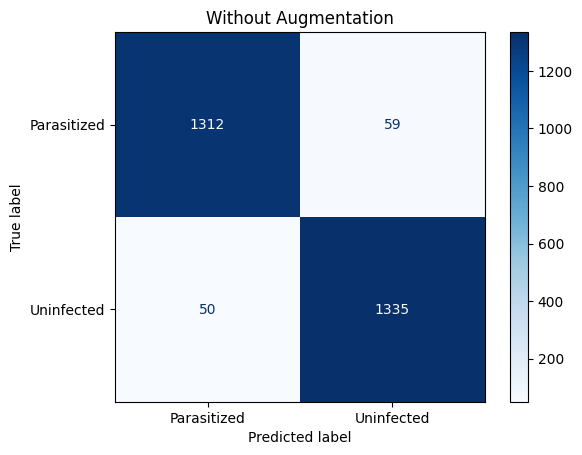

Confusion Matrix for Model With Augmentation:
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step


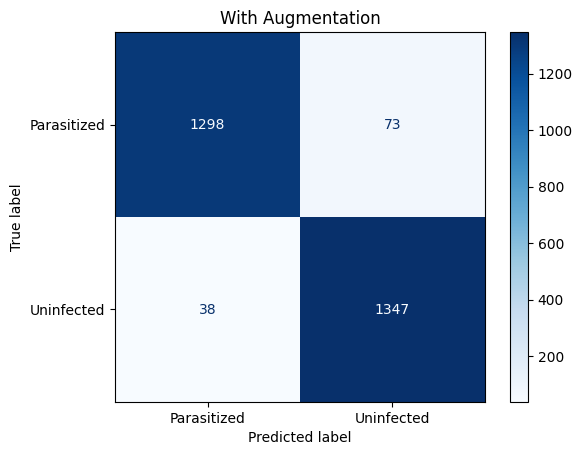

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix(model, test_data, title="Confusion Matrix"):
    """Generate and display the confusion matrix."""
    y_pred = (model.predict(test_data) > 0.5).astype(int).flatten()
    y_true = np.concatenate([y for _, y in test_data], axis=0)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Parasitized", "Uninfected"])
    
    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for both models
print("Confusion Matrix for Model Without Augmentation:")
plot_confusion_matrix(model_no_aug, test_data, title="Without Augmentation")

print("Confusion Matrix for Model With Augmentation:")
plot_confusion_matrix(model_aug, test_data, title="With Augmentation")


# Generate and Compare Classification Reports for Both Models

### Purpose:
- The classification report provides detailed metrics to evaluate the performance of both models:
  - **Precision**: The ratio of correctly predicted positive observations to the total predicted positive observations.
  - **Recall (Sensitivity)**: The ratio of correctly predicted positive observations to all actual positive observations.
  - **F1-Score**: The harmonic mean of precision and recall, offering a balance between the two metrics.
  - **Support**: The number of true instances for each class.

### Steps:
1. Predict labels for the test dataset using each model:
   - **Model Without Augmentation**: Baseline model trained on original data.
   - **Model With Augmentation**: Model trained on augmented data.
2. Compute the classification report for each model using `sklearn.metrics.classification_report`.
3. Display the classification report for each model to compare their performance.

### Insights:
- Helps evaluate how well each model performs for both classes (Parasitized and Uninfected).
- Provides detailed metrics for decision-making and model improvement.
- Highlights the impact of data augmentation on precision, recall, and F1-score.


In [21]:
from sklearn.metrics import classification_report

def print_classification_report(model, test_data, title="Classification Report"):
    """Print the classification report for a model."""
    y_pred = (model.predict(test_data) > 0.5).astype(int).flatten()
    y_true = np.concatenate([y for _, y in test_data], axis=0)
    print(f"{title}:\n")
    print(classification_report(y_true, y_pred, target_names=["Parasitized", "Uninfected"]))

# Generate classification reports
print_classification_report(model_no_aug, test_data, title="Model Without Augmentation")
print_classification_report(model_aug, test_data, title="Model With Augmentation")


87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step
Model Without Augmentation:

              precision    recall  f1-score   support

 Parasitized       0.96      0.96      0.96      1371
  Uninfected       0.96      0.96      0.96      1385

    accuracy                           0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step
Model With Augmentation:

              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      1371
  Uninfected       0.95      0.97      0.96      1385

    accuracy                           0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756



# **Observations and Results**

---

## **Training and Validation Performance**
1. **Without Augmentation**:
   - Achieved a high **validation accuracy of 96.04%**.
   - The training and validation loss converged well, indicating a well-fitted model.
   - There was no significant sign of overfitting, as validation metrics were close to training metrics.

2. **With Augmentation**:
   - Achieved a comparable **validation accuracy of 95.97%**.
   - Slight improvement in the **validation loss** (0.1380) compared to the non-augmented model (0.1489).
   - Data augmentation added variability to the training data, improving generalization slightly.

---

## **Confusion Matrices**
1. **Without Augmentation**:
   - **True Positives (Parasitized)**: 1312
   - **False Positives (Parasitized misclassified as Uninfected)**: 59
   - **True Negatives (Uninfected)**: 1335
   - **False Negatives (Uninfected misclassified as Parasitized)**: 50

2. **With Augmentation**:
   - **True Positives (Parasitized)**: 1298
   - **False Positives (Parasitized misclassified as Uninfected)**: 73
   - **True Negatives (Uninfected)**: 1347
   - **False Negatives (Uninfected misclassified as Parasitized)**: 38

### **Key Insights**:
- The model trained with augmentation reduced **False Negatives**, which is crucial for detecting parasitized cases.
- However, it slightly increased **False Positives**, leading to a trade-off between recall and precision.

---

## **Classification Reports**
1. **Without Augmentation**:
   - **Precision**: 96% for both classes.
   - **Recall**: 96% for both classes.
   - **F1-Score**: 96% for both classes.

2. **With Augmentation**:
   - **Precision**: Improved to **97%** for the Parasitized class.
   - **Recall**: Improved to **97%** for the Uninfected class.
   - **F1-Score**: 96% for both classes.

### **Key Insights**:
- Data augmentation slightly improved the balance between precision and recall, particularly for the "Parasitized" class.

---

## **General Observations**
- Both models performed exceptionally well, achieving high accuracy and balanced precision-recall metrics.
- Data augmentation helped reduce false negatives and slightly improved the balance between metrics, which could be beneficial in a real-world scenario where misclassifying parasitized cells as uninfected could have serious implications.

---

## **Conclusion**
1. **Best Model**: Both models performed comparably, but the augmented model demonstrated slightly better generalization and robustness to variability in the data.

